In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command


In [2]:
load_dotenv()

True

In [3]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=2)

In [4]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './files'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [5]:
from langchain_core.tools import BaseTool,tool
from langgraph.prebuilt.interrupt import HumanInterruptConfig,HumanInterrupt
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

In [6]:
def add_human_in_the_loop(toolhitl,interrupt_config: HumanInterruptConfig = None) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""

    if not isinstance(toolhitl, BaseTool):
        toolhitl = tool(toolhitl)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept":True,
            "allow_edit": True,
            "allow_respond":True
        }

    @tool(toolhitl.name,description=toolhitl.description,args_schema=toolhitl.args_schema)
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            'action_request':{
                "action":toolhitl.name,
                "args":tool_input
            },
            "config":interrupt_config,
            "description": "Please review the tool call"
        }

        response = interrupt([request])[0]

        # approve the tool call
        if response["type"] == "accept":
            tool_response = toolhitl.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = toolhitl.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response
    
    return call_tool_with_interrupt




In [7]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [8]:
result = arxiv_search("Quantum Machine Learning")

C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_13204\2627632007.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = arxiv_search("Quantum Machine Learning")
C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_13204\2323917343.py:18: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [9]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [10]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [11]:
# tools
tools = [arxiv_search,wikipedia_tool,youtube_tool,read_tool, add_human_in_the_loop(write_tool), list_tool,web_search_tool]

In [12]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [13]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [14]:
system_prompt = """ 
You are a reasoning agent that uses tools to answer questions.
You must always follow the Thought → Action → Action Input → Observation loop.

"""

In [15]:
def planner_node(state):
    user_query = state['messages']

    planner_prompt = ChatPromptTemplate([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])

    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state['messages']})
    print(result)

    return ({'messages':result}) 
    

In [16]:
graph = StateGraph(State)
checkpointer = InMemorySaver()
tool_node = ToolNode(tools)
graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')
graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile(checkpointer=checkpointer)

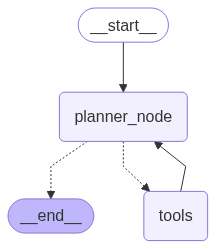

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
initial_state = {
    "messages": [HumanMessage(content="save a python code to find if the number is even or odd")]
}

config = {"configurable": {"thread_id": "890"}}

In [19]:
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

content='' additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "even_odd.py", "text": "\\ndef check_even_odd(number):\\n    if number % 2 == 0:\\n        return \\"Even\\"\\n    else:\\n        return \\"Odd\\"\\n\\n# Example usage:\\nnum = int(input(\\"Enter a number: \\"))\\nresult = check_even_odd(num)\\nprint(f\\"The number {num} is {result}.\\")\\n"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--dd50e8c0-cc58-4d27-8bd4-2a973f862a7e-0' tool_calls=[{'name': 'write_file', 'args': {'file_path': 'even_odd.py', 'text': '\ndef check_even_odd(number):\n    if number % 2 == 0:\n        return "Even"\n    else:\n        return "Odd"\n\n# Example usage:\nnum = int(input("Enter a number: "))\nresult = check_even_odd(num)\nprint(f"The number {num} is {result}.")\n'}, 'id': '32487d2a-80a2-46cb-b5b9-5f89bfc37bd1', 'type': 'tool_call'}]

In [20]:
chunk['messages'][-1].content

''

In [21]:
chunk

{'messages': [HumanMessage(content='save a python code to find if the number is even or odd', additional_kwargs={}, response_metadata={}, id='c6660707-3dc1-4442-bbaa-0111e085a1a1'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "even_odd.py", "text": "\\ndef check_even_odd(number):\\n    if number % 2 == 0:\\n        return \\"Even\\"\\n    else:\\n        return \\"Odd\\"\\n\\n# Example usage:\\nnum = int(input(\\"Enter a number: \\"))\\nresult = check_even_odd(num)\\nprint(f\\"The number {num} is {result}.\\")\\n"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--dd50e8c0-cc58-4d27-8bd4-2a973f862a7e-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'even_odd.py', 'text': '\ndef check_even_odd(number):\n    if number % 2 == 0:\n        return "Even"\n    else:\n        return "Odd"\n\n

In [22]:
from langgraph.types import Command
user_input = input("Do you accept: ?")

for chunk in graph.stream(
    Command(resume=[{"type": user_input}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content="Error: ValueError('Unsupported interrupt response type: no')\n Please fix your mistakes.", name='write_file', id='eb3570cb-6937-4329-9c63-5eb90e5d8038', tool_call_id='32487d2a-80a2-46cb-b5b9-5f89bfc37bd1', status='error')]}}


content='' additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "even_odd.py", "text": "\\ndef check_even_odd(number):\\n    if number % 2 == 0:\\n        return \\"Even\\"\\n    else:\\n        return \\"Odd\\"\\n\\n# Example usage:\\nnum = int(input(\\"Enter a number: \\"))\\nresult = check_even_odd(num)\\nprint(f\\"The number {num} is {result}.\\")\\n"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--51822d3f-1691-4976-b7ca-72495f1d816a-0' tool_calls=[{'name': 'write_file', 'args': {'file_path': 'even_odd.py', 'text': '\ndef check_even_odd(number):\n    if nu